In [1]:
from __future__ import absolute_import # need it for metaseq import in py27
import os
from IPython.display import IFrame
import pandas as pd
import sys
import numpy as np
sys.path.insert(0, '../JKBio/')
import ChIPHelper
import itertools
import igv
import pysam
import Datanalytics as da
import Helper
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import matplotlib
import bokeh
from bokeh.io import output_notebook
import multiprocessing
processes = multiprocessing.cpu_count()
output_notebook()
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipyparallel as ipp
#rc = ipp.Client()
#with rc[:].sync_imports():
#    import numpy
#    import pandas as pd
#    import pysam
#    import sys
#%px sys.path.insert(0, '../JKBio/')
#with rc[:].sync_imports():
   # import ChIPHelper

ModuleNotFoundError: No module named 'ChIPHelper'

### Let's build the indexes with bowtie2  

In [2]:
! bowtie2-build data/reference/reference.fa data/reference/index --threads 8

Settings:
  Output files: "data/reference/index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 32
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/reference/reference.fa
Building a SMALL index
Reading reference sizes
^C


## adding the data bucket to path

In [2]:
! gcsfuse --only-dir Chip_AML jkobject data/seqs

Using mount point: /home/jeremie/AMLproject/data/seqs
Opening GCS connection...
Opening bucket...
Mounting file system...
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithConn: Mount: mount: running fusermount: exit status 1

stderr:
fusermount: failed to access mountpoint /home/jeremie/AMLproject/data/seqs: Permission denied



## extracting which one is single end and paired end

### Renaming ill formatted files

In [ ]:
! mv mp183-MV411-DMSO-H3K27ac-r1.fastq.gz mp183-MV411-DMSO_H3K27ac-r1.fastq.gz
! mv mp718-MV411-IRF2BP2-r9_R1_001.fastq.gz mp718-MV411-IRF2BP2-r9_R1.fastq.gz
! mv mp717-MV411-GATA2-r4_R1_001.fastq.gz mp717-MV411-GATA2-r4_R1.fastq.gz
! mv mp716-MV411-GSE1-r9_R1_001.fastq.gz mp716-MV411-GSE1-r9_R1.fastq.gz
! mv mp715-MV411-ZEB2-r8_R1_001.fastq.gz mp715-MV411-ZEB2-r8_R1.fastq.gz
! mv mp714-MV411-ZEB2-r7_R1_001.fastq.gz mp714-MV411-ZEB2-r7_R1.fastq.gz
! mv mp702-MV411_DMSO_8h-H3K27ac-r2.fastq.gz mp702-MV411-DMSO_8h_H3K27ac-r2.fastq.gz
! mv mp690-MV411_DMSO_8h-MAX-r1.fastq.gz mp690-MV411-DMSO_8h_MAX-r1.fastq.gz

In [3]:
singlend, paired_end, pairedendict = ChIPHelper.extractPairedSingleEndFrom(folder='data/seqs/')

In [10]:
data = {'group': [], 'replicate': [], 'fastq_1': [], 'fastq_2': [], 'antibody': [], 'control': []}
for rfile in singlend:
# should end with r2
    dfile = rfile.split('.')[0].split('-')
    data['group'].append(dfile[2])
    data['antibody'].append('')
    data['control'].append('INPUT')
    data['replicate'].append(data['group'].count(dfile[2]))
    data['fastq_1'].append('data/seqs/' + rfile)
    data['fastq_2'].append('')

In [12]:
pd.DataFrame(data, columns=['group', 'replicate', 'fastq_1', 'fastq_2', 'antibody', 'control']).to_csv('singleend.csv',index=False)

In [25]:
controlfile=True
control = 'INPUT'
path_to_fastq = 'data/seqs/'

In [45]:
data = {'group': [], 'replicate': [], 'fastq_1': [], 'fastq_2': [], 'antibody': [], 'control': []}
for file1, file2 in Helper.grouped(paired_end, 2):
  # should end with r2
    dfile = file1.split('.')[0].split('-')
    data['group'].append(dfile[2])
    data['antibody'].append('')
    data['control'].append(control if control != dfile[2] else '')
    data['replicate'].append(dfile[3].split('r')[1][0])
    data['fastq_1'].append(path_to_fastq + file1)
    data['fastq_2'].append(path_to_fastq + file2)
if not controlfile:
    raise('we need control file')
    pd.DataFrame(data, columns=['group','replicate','fastq_1','fastq_2','antibody','control']).to_csv('design_paired.csv', index=False)

In [46]:
data = {'group': [], 'replicate': [], 'fastq_1': [], 'fastq_2': [], 'antibody': [], 'control': []}
for file1, file2 in Helper.grouped(paired_end, 2):
  # should end with r2
    dfile = file1.split('.')[0].split('-')
    data['group'].append(dfile[2])
    data['antibody'].append('')
    data['control'].append(control if control != dfile[2] else '')
    data['replicate'].append(dfile[3].split('r')[1][0])
    data['fastq_1'].append(path_to_fastq + file1)
    data['fastq_2'].append(path_to_fastq + file2)
if not controlfile:
    raise('we need control file')
    pd.DataFrame(data, columns=['group','replicate','fastq_1','fastq_2','antibody','control']).to_csv('design_paired.csv', index=False)

In [47]:
ChIPHelper.executeNFcore('data/seqs/')

AttributeError: 'module' object has no attribute 'executeNFcore'

## Aligning and computing peaks 

We have witnessed some warnings on the data for :

- POLII-r1
- MEF2D-r1_R1
- ZMYND8-r2
- GATA2-r4_R1_001

and maybe more 

In [ ]:
#paired end
CPU = 8
ChIPHelper.computeSingleEnd(singlend,CPU = CPU)

data/mapped/mp112-MV411-CEBPA-r2.bam
data/mapped/mp116-MV411-MYB-r2.bam
data/mapped/mp117-MV411-POLII-r1.bam
data/mapped/mp134-MV411-IGG-r1.bam
data/mapped/mp183-MV411-DMSO-H3K27ac-r1.bam
data/mapped/mp357-MV411-ZMYND8-r1.bam
data/mapped/mp358-MV411-ZMYND8-r2.bam
data/mapped/mp359-MV411-LMO2-r1.bam
data/mapped/mp424-MV411-RUNX1-r4.bam
data/mapped/mp425-MV411-ETV6-r3.bam
data/mapped/mp426-MV411-SP1-r3.bam
data/mapped/mp427-MV411-LMO2-r2.bam
data/mapped/mp428-MV411-PU1-r3.bam
data/mapped/mp429-MV411-IRF8-r2.bam
data/mapped/mp430-MV411-IRF2BP2-r1.bam
data/mapped/mp431-MV411-IRF2BP2-r2.bam
data/mapped/mp433-MV411-GSE1-r1.bam
data/mapped/mp435-MV411-MED1-r2.bam
data/mapped/mp569-MV411-ETV6-r4.bam
data/mapped/mp570-MV411-CTCF-r1.bam
data/mapped/mp575-MV411-IRF2BP2-r3.bam
data/mapped/mp577-MV411-SMC1-r1.bam
data/mapped/mp581-MV411-MEF2C-r1.bam
data/mapped/mp582-MV411-MEIS1-r1.bam
data/mapped/mp583-MV411-ELF2-r1.bam
data/mapped/mp584-MV411-MYC-r2.bam
data/mapped/mp585-MV411-MYC-r3.bam
data/map

In [39]:
ChIPHelper.computePairedEnd(pairedendict,CPU = CPU)

data/mapped/mp106-MV411-MYB-r1.bam
data/mapped/mp112-MV411-CEBPA-r2.bam
data/mapped/mp116-MV411-MYB-r2.bam
data/mapped/mp117-MV411-POLII-r1.bam
data/mapped/mp134-MV411-IGG-r1.bam
data/mapped/mp183-MV411-DMSO-H3K27ac-r1.bam
data/mapped/mp357-MV411-ZMYND8-r1.bam
data/mapped/mp358-MV411-ZMYND8-r2.bam
data/mapped/mp359-MV411-LMO2-r1.bam
data/mapped/mp424-MV411-RUNX1-r4.bam
data/mapped/mp425-MV411-ETV6-r3.bam
data/mapped/mp426-MV411-SP1-r3.bam
data/mapped/mp427-MV411-LMO2-r2.bam
data/mapped/mp428-MV411-PU1-r3.bam
data/mapped/mp429-MV411-IRF8-r2.bam
data/mapped/mp430-MV411-IRF2BP2-r1.bam
data/mapped/mp431-MV411-IRF2BP2-r2.bam
data/mapped/mp433-MV411-GSE1-r1.bam
data/mapped/mp435-MV411-MED1-r2.bam
data/mapped/mp569-MV411-ETV6-r4.bam
data/mapped/mp570-MV411-CTCF-r1.bam
data/mapped/mp575-MV411-IRF2BP2-r3.bam
data/mapped/mp577-MV411-SMC1-r1.bam
data/mapped/mp581-MV411-MEF2C-r1.bam
data/mapped/mp582-MV411-MEIS1-r1.bam
data/mapped/mp583-MV411-ELF2-r1.bam
data/mapped/mp584-MV411-MYC-r2.bam
data/map

In [5]:
ChIPHelper.bigWigFrom('data/mapped/')

considering directory
bamCoverage -b data/mapped/mp584-MV411-MYC-r2.bam -o data/mapped/mp584-MV411-MYC-r2.bw --binSize 10 --ignoreForNormalization chrX --extendReads
bamCoverage -b data/mapped/mp88-MV411-H3K27ac-r2.bam -o data/mapped/mp88-MV411-H3K27ac-r2.bw --binSize 10 --ignoreForNormalization chrX --extendReads
bamCoverage -b data/mapped/mp575-MV411-IRF2BP2-r3.bam -o data/mapped/mp575-MV411-IRF2BP2-r3.bw --binSize 10 --ignoreForNormalization chrX --extendReads
bamCoverage -b data/mapped/mp717-MV411-GATA2-r4_R1_001.bam -o data/mapped/mp717-MV411-GATA2-r4_R1_001.bw --binSize 10 --ignoreForNormalization chrX --extendReads
bamCoverage -b data/mapped/mp715-MV411-ZEB2-r8_R1_001.bam -o data/mapped/mp715-MV411-ZEB2-r8_R1_001.bw --binSize 10 --ignoreForNormalization chrX --extendReads
bamCoverage -b data/mapped/mp358-MV411-ZMYND8-r2.bam -o data/mapped/mp358-MV411-ZMYND8-r2.bw --binSize 10 --ignoreForNormalization chrX --extendReads
bamCoverage -b data/mapped/mp690-MV411_DMSO_8h-MAX-r1.bam -o

null device 
          1 


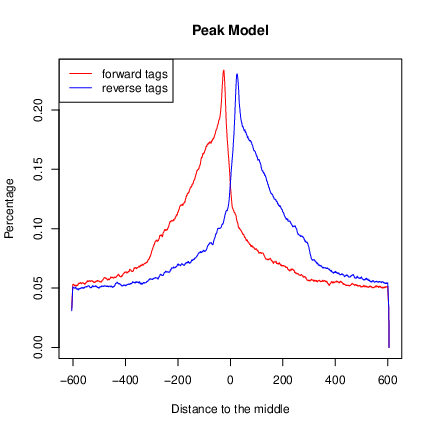

In [50]:
! Rscript data/peaks/mp585-MV411-MYC-r3/NA_model.r
from wand.image import Image as WImage
img = WImage(filename='NA_model.pdf')
img

## Analyzing the peaks

In [2]:
bindings = ChIPHelper.loadNarrowPeaks(path='data/peaks/')

looking at folder of macs peaks


/home/jeremie/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
SEgenes = pd.read_csv('SEgenes.csv')
CTF = pd.read_csv('CTF.csv', header=None)[0].tolist()

In [5]:
set(bindings.type.tolist())- set(CTF)

{'CTCF',
 'DMSO',
 'DMSO_8h_H3K27ac',
 'DMSO_8h_MAX',
 'GATA2',
 'H3K27ac',
 'IGG',
 'IKZF1',
 'INPUT',
 'LYL1',
 'MAX',
 'MED1',
 'POLII',
 'PU1',
 'SMC1'}

In [6]:
CTF.extend(['GATA2','IKZF1','LYL1' ,'PU1','SMC1'])

In [7]:
CTF = list(set(CTF) - (set(CTF) - set(bindings.type.tolist())))
CTF

['ZMYND8',
 'ELF2',
 'IKZF1',
 'PU1',
 'GSE1',
 'CEBPA',
 'SMC1',
 'MEIS1',
 'IRF2BP2',
 'MYC',
 'MYB',
 'MEF2C',
 'LYL1',
 'SP1',
 'FLI1',
 'GATA2',
 'ZEB2',
 'GFI1',
 'ETV6',
 'LMO2',
 'IRF8',
 'RUNX2',
 'RUNX1',
 'MEF2D']

In [8]:
bindings = bindings.reset_index().drop('index',1)

In [9]:
zones = ChIPHelper.mergePeaks(bindings, 1000, TFlist = CTF)

In [10]:
zones.shape

(342753, 35)

In [11]:
zones['score'] = zones['score'].values/ np.linalg.norm(zones['score'].values)
zones['foldchange'] =  zones['foldchange'].values / np.linalg.norm(zones['foldchange'].values)
for val in CTF:
    zones[val] = zones[val] / np.linalg.norm(zones[val])

In [89]:
zones[zones.columns[:10]].to_csv('mergepeaks.narrowPeak', sep='\t', header=None, index=False)

In [12]:
zones.to_csv('saved.csv')

In [7]:
zones = pd.read_csv('saved.csv',index_col=0)

/home/jeremie/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
zones

,chromosome,start,end,peaks_number,score,strand,foldchange,confidencep,confidenceq,relative_summit_pos,...,FLI1,GATA2,ZEB2,GFI1,ETV6,LMO2,IRF8,RUNX2,RUNX1,MEF2D
0,1,9943,11338,0,0.001617,.,0.001483,260.28238,240.50010,192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004605,0.000000,0.000000,0.000000
1,1,15488,16416,1,0.000143,.,0.000335,28.56261,21.39418,71,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,26046,26195,2,0.000067,.,0.000146,12.44543,10.01159,508,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,28853,30115,3,0.000908,.,0.001318,151.87216,134.99842,120,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002298,0.000000,0.000000,0.000000
4,1,54923,55136,4,0.000065,.,0.000201,12.17878,9.75096,82,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1,75698,75881,5,0.000073,.,0.000220,13.34560,10.87839,124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1,90644,91551,6,0.000432,.,0.000608,70.27809,64.16623,186,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1,96461,96715,7,0.000203,.,0.000564,37.79515,30.25066,91,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,104174,105138,8,0.000118,.,0.000358,22.82375,17.61243,92,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1,133927,134141,9,0.000080,.,0.000232,14.47199,11.97679,54,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Correlation Matrix

In [91]:
Helper.plotCorrelationMatrix(zones[zones.columns[11:]].T, names=zones.columns.tolist()[11:])

In [9]:
path = "data/mapped/"
zones = pd.read_csv('saved.csv',index_col=0)
MYC = pysam.AlignmentFile(path+"mp585-MV411-MYC-r3.bam", "rb")
RUNX1= pysam.AlignmentFile(path+"mp300-MV411-RUNX1-r3_R1.bam", "rb")
ZEB2= pysam.AlignmentFile(path+"mp320-MV411-ZEB2-r1_R1.bam", "rb")
SP1= pysam.AlignmentFile(path+"mp325-MV411-SP1-r2_R1.bam", "rb")
MEF2D= pysam.AlignmentFile(path+"mp324-MV411-MEF2D-r1_R1.bam", "rb")
df = zones.sort_values(by=["MYC"],axis=0, ascending=False).reset_index()

In [10]:
df = ChIPHelper.loadNarrowPeaks("data/peaks/mp585-MV411-MYC-r3/NA_peaks.narrowPeak")
df = df.sort_values(by=["foldchange"],axis=0, ascending=False).reset_index()

looking at narrowpeak file


In [11]:
df.iloc[18000]

index                          1840
chromosome                        1
start                     182614970
end                       182615163
peak_number            NA_peak_1841
score                            51
strand                            .
foldchange                  5.26215
-log10pvalue                8.20814
-log10qvalue                5.19164
relative_summit_pos              72
Name: 18000, dtype: object

In [ ]:
MYC.

In [ ]:
group = 500
CPU = 8
#with Pool(CPU) as p:
MYC = ChIPHelper.computePeaksAt(df,MYC,2000,20000, window=1000)
MEF2D = ChIPHelper.computePeaksAt(df,MEF2D,2000,20000, window=1000)
SP1 = ChIPHelper.computePeaksAt(df,SP1,2000,20000, window=1000)
RUNX1 = ChIPHelper.computePeaksAt(df,RUNX1,2000,20000, window=1000)


In [ ]:
ZEB2 = ChIPHelper.computePeaksAt(df,ZEB2,2000,20000, window=1000)

# Peak Profile accross highest MYC peaks

In [117]:
normMYC = MYC[np.argsort(MYC.sum(1))[::-1]]
normMYC = normMYC / np.max(normMYC,1)[:,None]
normMEF2D = MEF2D[np.argsort(MYC.sum(1))[::-1]]
normMEF2D = normMEF2D / np.max(normMEF2D,1)[:,None]
normSP1 = SP1[np.argsort(MYC.sum(1))[::-1]]
normSP1 = normSP1 / np.max(normSP1,1)[:,None]
normRUNX1 = RUNX1[np.argsort(MYC.sum(1))[::-1]]
normRUNX1 = normRUNX1 / np.max(normRUNX1,1)[:,None]


/home/jeremie/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


In [60]:
normMYC = normMYC[np.argsort(normMYC.sum(1))[::-1]]

In [118]:
MYC.shape

(20000, 2000)

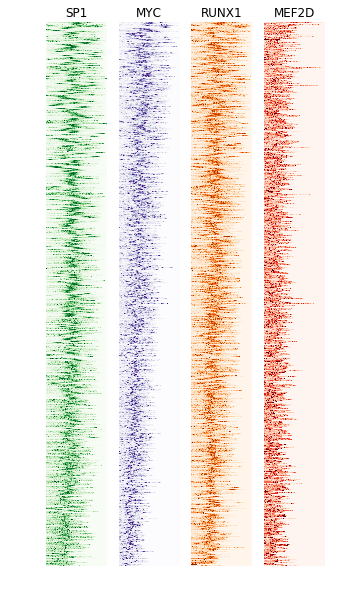

In [120]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (5,10))
plt.box(on=None)
plt.axis('off')
ax = []
TFs = {'MYC':normMYC,'RUNX1':normRUNX1,'SP1':normSP1,'MEF2D':normMEF2D}
i = 1
cmap = ['Blues','Greens','Purples','Oranges', 'Reds']
for key, tf in TFs.iteritems():
    ax = [fig.add_subplot(1,len(TFs) , i)]
    i+=1
    plt.box(on=None)
    ax[-1].set_title(key)
    ax[-1].axis('off')
    plt.imshow(tf, interpolation='nearest', aspect='auto', cmap=cmap[i-1],vmax=1)
plt.savefig("TFs_MYC")

In [88]:
a = [0,1,1,2,3,4,3,0,0,0,0,0]
size = 5
np.convolve(a, np.ones((size,)) / size, mode='valid')

array([1.4, 2.2, 2.6, 2.4, 2. , 1.4, 0.6, 0. ])

In [17]:
data = zones[zones.columns[11:]]
data = np.log2(data.values+1)

In [18]:
model = AgglomerativeClustering(n_clusters=2,linkage="average", affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(data.T)
ii = itertools.count(data.T.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [108]:
Helper.scatter(TSNE(2,5).fit_transform(data.T), labels=zones.columns[11:],colors=labels)

In [109]:
Helper.plotCorrelationMatrix(zones[zones.columns[[11+i for i in labels.argsort()]]].T, names=zones.columns[[11+i for i in labels.argsort()]].tolist())

In [56]:
b = igv.Browser({"genome": "hg38"})

In [58]:
#b.load_track({
#    "type": "wig",
#    "format": "bigWig",
#    "name": "RUNX1",
#    "url": "data/mapped/mp300-MV411-RUNX1-r3_R1.bw",
#    "sourceType":"file",
#})
#b.load_track({
#    "name": "RUNX1peaks",
#    "url": "data/peaks/mp300-MV411-RUNX1-r3_R1/NA_peaks.narrowPeak",
#    "format": "narrowPeak",
#    "type": "annotation",
#    "indexed": False,
#    "displayMode": "COLLAPSED"
#})
#b.load_track({
#    "type": "wig",
#    "format": "bigWig",
#    "name": "PU1",
#    "url": "data/mapped/mp301-MV411-PU1-r2_R1.bw",
#    "sourceType":"file",
#})
#b.load_track({
#    "name": "PU1peaks",
#    "url": "data/peaks/mp301-MV411-PU1-r2_R1/NA_peaks.narrowPeak",
#    "format": "narrowPeak",
#    "type": "annotation",
#    "indexed": False,
#    "displayMode": "COLLAPSED"
#})
b.load_track({
    "type": "wig",
    "format": "bigWig",
    "name": "MYC",
    "url": "data/mapped/mp301-MV411-PU1-r2_R1.bw",
    "sourceType":"file",
})
b.load_track({
    "name": "MYCpeaks",
    "url": "data/peaks/mp585-MV411-MYC-r3/NA_peaks.narrowPeak",
    "format": "narrowPeak",
    "type": "annotation",
    "indexed": False,
    "displayMode": "COLLAPSED"
})
b.load_track({
    "name": "Mergedpeaks",
    "url": "mergepeaks.narrowPeak",
    "format": "narrowPeak",
    "type": "annotation",
    "indexed": False,
    "displayMode": "COLLAPSED"
})

'OK'

In [57]:
b.show()

### TO remove
- IgG: basically no binding
- DMSO: control substance (MYC?) what is non control?
- CTCF, 
- H3K27ac, 
- MAX: should be bound at all MYC peaks
- POLII: RNA polymerase 2. should be at all transcribed sites (and thus at all chip peaks)
- MED1: help POL2

In [21]:
minval = np.argsort(np.count_nonzero(data,0))

## What coverage can we achieve with 2, 3 TFs

In [27]:
maxv = 0
for i in range(len(minval)):
    for j in range(len(minval)):
        tot = data[:,j] + data[:,i]
        if float(np.count_nonzero(tot)) / data.shape[0] > maxv:
            keep = [i,j]
            maxv = float(np.count_nonzero(tot)) / data.shape[0]
print(maxv,zones.columns[11:][keep])

(0.5283192269651906, Index([u'PU1', u'CEBPA'], dtype='object'))


In [49]:
maxv = 0
for i in range(len(minval)):
    for j in range(len(minval)):
        for k in range(len(minval)):
            tot = data[:,k] + data[:,j] + data[:,i]
            if float(np.count_nonzero(tot)) / data.shape[0] > maxv:
                keep = [i,j,k]
                maxv = float(np.count_nonzero(tot)) / data.shape[0]

In [50]:
print(maxv,zones.columns[11:][keep])

(0.6387281803514484, Index([u'PU1', u'CEBPA', u'SMC1'], dtype='object'))


## What is the best coverage we can achieve with 5 TFs

In [51]:
for l in range(len(minval)):
    for m in range(len(minval)):
        tot = data[:,keep[0]] + data[:,keep[1]] + data[:,keep[2]] + data[:,l] + data[:,m]
        if float(np.count_nonzero(tot)) / data.shape[0] > maxv:
            keepadd = [l,m]
            maxv = float(np.count_nonzero(tot)) / data.shape[0]

In [52]:
print(maxv,zones.columns[11:][keepadd])

(0.782327215224958, Index([u'MEIS1', u'GATA2'], dtype='object'))


## Sum of the X most bound TFs

In [43]:
float(np.count_nonzero(np.sum(data[:,minval[-3:]],1))) / data.shape[0]

0.5574743328285967

## Most globally bound TFs

In [363]:
zones.columns[11:][minval[-6:]]

Index([u'CEBPA', u'FLI1', u'SMC1', u'MEIS1', u'IRF8', u'PU1'], dtype='object')

## Recap
here we have confirmed that POL2 is present at all merged peaks. and that IgG is only present at 0.4% of mergedpeaks. we confirmed that MED1 is present in almost all POL2 merged peaks
why IgG and POL2 are very correlated?? should not be the case..


CEBPA covers 96% of all tfs, 97% are covered by adding MEF2D and ZEB2. 98.5% by adding IKZF1 and GSE1

CEBPA, FLI1, SMC1, MEIS1, IRF8, PU1 together summarize 99.97% of the merged peaks